# Community Detection

In [1]:
## Notebook config

import sys
if '../' not in sys.path:
    sys.path.append("../")
%load_ext dotenv
%reload_ext dotenv
%dotenv

In [2]:
# Notebook imports
import ast
import os
import pickle
import collections 
import csv


from graphdatascience import GraphDataScience
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import umap

/home/rnalab/ljp/.conda/envs/ljp/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
DATASET_DIR = './dataset/'
PROJECTION_NAME_PREFIX = 'anomaly_projection_'
RANDOM_SEED = 42

NEO4J_URI = os.environ.get('NEO4J_URI')
NEO4J_USER = os.environ.get('NEO4J_USER')
NEO4J_PASSWORD = os.environ.get('NEO4J_PASSWORD')


In [76]:
# GDS utils
def get_gds_client():
    return GraphDataScience(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASSWORD))

def get_projection_name(version=1):
    return PROJECTION_NAME_PREFIX + str(version)

def get_projection(gds, projection_name):
    if gds.graph.exists(projection_name)['exists']:
        return gds.graph.get(projection_name)
    projection = gds.graph.project(
        graph_name=projection_name,
        node_spec={
            'Fasta': {},
            'Hit': {},
            'HitFamily': {},
            'HitRegion': {},
        },
        relationship_spec={
            'hasHit': {'orientation': 'UNDIRECTED', 'properties': {'score': {'defaultValue': 1}}},
            'hasRegion': {'orientation': 'UNDIRECTED', 'properties': {'score': {'defaultValue': 1}}},
            'hasAffiliate': {'orientation': 'UNDIRECTED', 'properties': {'sum_probs': {'defaultValue': 1}}},
            'hasMember': {'orientation': 'UNDIRECTED', 'properties': {'probab': {'defaultValue': 1}}},
            'hasDownstream': {'orientation': 'UNDIRECTED', 'properties': {'score': {'defaultValue': 1}}},
        },
    )
    return projection

def delete_projection(gds, projection_name):
    if gds.graph.exists(projection_name)['exists']:
        gds.graph.drop(gds.graph.get(projection_name))


In [77]:
# Create GDS projection

version = 1
projection_name = get_projection_name(version)
gds = get_gds_client()
delete_projection(gds, projection_name)
projection = get_projection(gds, projection_name)
print(projection)

GraphCreateResult(graph=Graph({'graphName': 'anomaly_projection_1', 'nodeCount': 148782, 'relationshipCount': 787238, 'database': 'neo4j', 'configuration': {'relationshipProjection': {'hasHit': {'aggregation': 'DEFAULT', 'orientation': 'UNDIRECTED', 'indexInverse': False, 'properties': {'score': {'aggregation': 'DEFAULT', 'property': 'score', 'defaultValue': 1}}, 'type': 'hasHit'}, 'hasMember': {'aggregation': 'DEFAULT', 'orientation': 'UNDIRECTED', 'indexInverse': False, 'properties': {'probab': {'aggregation': 'DEFAULT', 'property': 'probab', 'defaultValue': 1}}, 'type': 'hasMember'}, 'hasRegion': {'aggregation': 'DEFAULT', 'orientation': 'UNDIRECTED', 'indexInverse': False, 'properties': {'score': {'aggregation': 'DEFAULT', 'property': 'score', 'defaultValue': 1}}, 'type': 'hasRegion'}, 'hasDownstream': {'aggregation': 'DEFAULT', 'orientation': 'UNDIRECTED', 'indexInverse': False, 'properties': {'score': {'aggregation': 'DEFAULT', 'property': 'score', 'defaultValue': 1}}, 'type': 'h

componentCount 53
componentDistribution {'min': 1, 'p5': 4, 'max': 146734, 'p999': 146734, 'p99': 146734, 'p1': 1, 'p10': 6, 'p90': 76, 'p50': 25, 'p25': 10, 'p75': 61, 'p95': 178, 'mean': 2807.2075471698113}
postProcessingMillis 5
preProcessingMillis 0
computeMillis 86
configuration {'jobId': '6efa230f-0660-4560-aa99-c25e6a91bbc1', 'logProgress': True, 'nodeLabels': ['*'], 'relationshipTypes': ['*'], 'concurrency': 4, 'consecutiveIds': False, 'sudo': False}


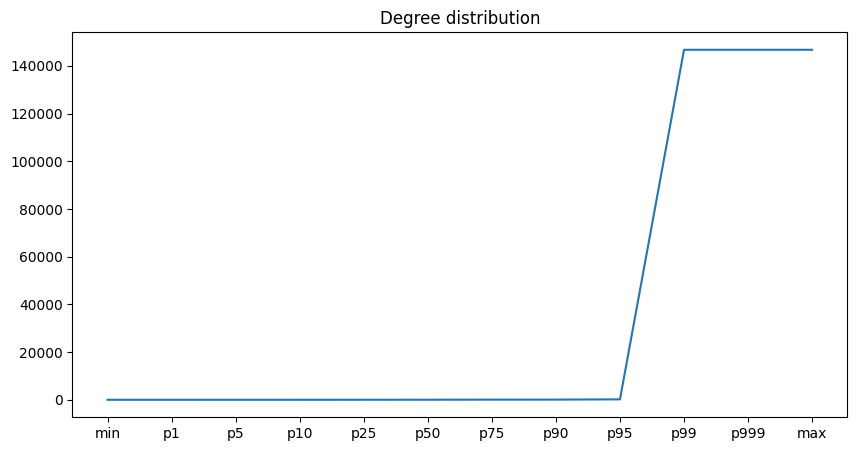

In [81]:
stats = gds.scc.stats(
    G=gds.graph.get(projection_name),
    nodeLabels=["*"],
    relationshipTypes=["*",],
)
for key, value in stats.items():
    print(f"{key} {value}")

# With all hitFamilies
# componentCount 53
# With no hitfamilies
# componentCount 6698


def plot_percentiles(stats):
    plt.figure(figsize=(10, 5))
    ordered_percentile_keys = [
        'min', 'p1', 'p5', 'p10', 'p25', 'p50', 'p75', 'p90', 'p95', 'p99', 'p999', 'max'
    ]
    ordered_percentile_values = [stats['componentDistribution'][key] for key in ordered_percentile_keys]
    plt.plot(ordered_percentile_keys, ordered_percentile_values)
    plt.title('Degree distribution')
    plt.show()

plot_percentiles(stats)

In [87]:
# drop graph if it exists
if gds.graph.exists('filtered')['exists']:
    gds.graph.drop(gds.graph.get('filtered'))

gds.graph.filter(
    graph_name='filtered',
    from_G=gds.graph.get(projection_name),
    node_filter="*",
    node_filter="n:Fasta OR n:Hit OR n:HitRegion OR (n:HitFamily AND n.sum_probs > 5.0)",
    # relationship_filter="r:hasHit OR r:hasRegion OR r:hasMember OR r:hasDownstream",
    relationship_filter="(r:hasAffiliate AND r.sum_probs > 5.0) OR r:hasHit OR r:hasRegion OR r:hasMember OR r:hasDownstream",
)

GraphCreateResult(graph=Graph({'graphName': 'filtered', 'nodeCount': 148782, 'relationshipCount': 555412, 'database': 'neo4j', 'configuration': {'relationshipProperties': {}, 'jobId': '4f6ed64b-21b5-4b7e-9537-b8a40220d135', 'validateRelationships': False, 'nodeFilter': '*', 'sudo': False, 'relationshipProjection': {'hasHit': {'aggregation': 'DEFAULT', 'orientation': 'UNDIRECTED', 'indexInverse': False, 'properties': {'score': {'aggregation': 'DEFAULT', 'property': 'score', 'defaultValue': 1}}, 'type': 'hasHit'}, 'hasMember': {'aggregation': 'DEFAULT', 'orientation': 'UNDIRECTED', 'indexInverse': False, 'properties': {'probab': {'aggregation': 'DEFAULT', 'property': 'probab', 'defaultValue': 1}}, 'type': 'hasMember'}, 'hasRegion': {'aggregation': 'DEFAULT', 'orientation': 'UNDIRECTED', 'indexInverse': False, 'properties': {'score': {'aggregation': 'DEFAULT', 'property': 'score', 'defaultValue': 1}}, 'type': 'hasRegion'}, 'hasDownstream': {'aggregation': 'DEFAULT', 'orientation': 'UNDIRE

componentCount 148
componentDistribution {'min': 1, 'p5': 1, 'max': 146639, 'p999': 146639, 'p99': 213, 'p1': 1, 'p10': 1, 'p90': 61, 'p50': 1, 'p25': 1, 'p75': 10, 'p95': 70, 'mean': 1005.2837837837837}
postProcessingMillis 5
preProcessingMillis 0
computeMillis 67
configuration {'jobId': '9dac41fc-730e-4450-818d-b55ae3916ac6', 'logProgress': True, 'nodeLabels': ['*'], 'relationshipTypes': ['*'], 'concurrency': 4, 'consecutiveIds': False, 'sudo': False}


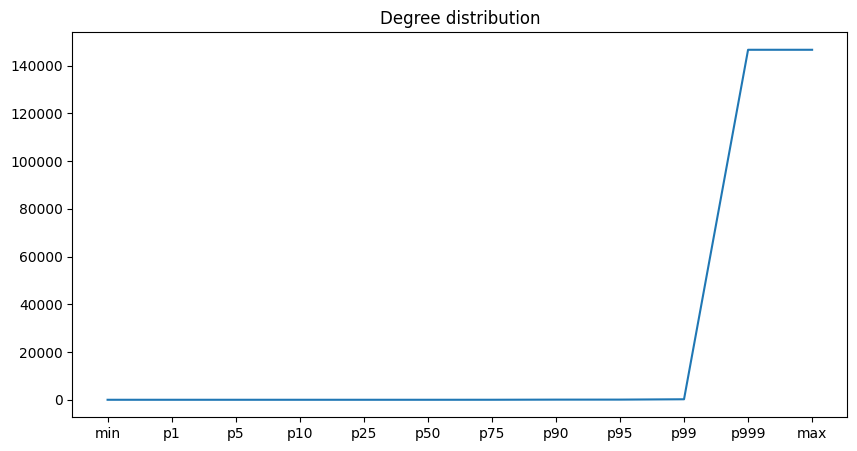

In [88]:
stats = gds.scc.stats(
    G=gds.graph.get('filtered'),
    nodeLabels=["*"],
    relationshipTypes=["*",],
)
for key, value in stats.items():
    print(f"{key} {value}")


plot_percentiles(stats)


In [ ]:
# remove excess hitfamilies
# MATCH (n:HitFamily)-[r]->(:Hit)<-[r2]-(:HitRegion)
# WHERE r2.representation = True
# WITH n, count(r) as relCount
# ORDER BY relCount DESC LIMIT 10
# MATCH (n)--(m:Hit)
# RETURN DISTINCT n, relCount

# remove non-representative hitfamilies
# MATCH p=()-[r:hasAffiliate]->() RETURN COUNT(p) LIMIT 25
# 22742/118275